##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

plt.style.use('seaborn')

np.__version__


/tmp/ipykernel_3830/806828465.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

## Q1: Own Calibration

#### Loading the image

Resized the image to (1080, 720) because it was too large and working with it consumed a lot of memory and time. Moreover, all the results can be reprodcued with the original image size too.

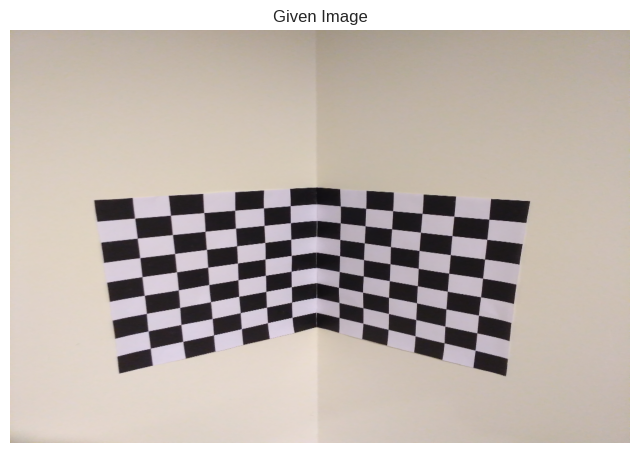

In [2]:
img = cv2.imread('./Data/calib-object.jpg')
img = cv2.resize(img, (1080, 720))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title('Given Image')
plt.axis('off')
plt.show()


#### 1. Detecting Corners

Used ```cv2.goodFeaturesToTrack()``` function to find corners with parameters: ```maxCorners=200, qualityLevel=0.15,  minDistance=10```

```cv2.goodFeaturesToTrack()``` is a function in the OpenCV library that is used for detecting corners in an image. It is based on the Shi-Tomasi corner detection algorithm, which is an improvement over the Harris corner detection method

Total corners found: 80


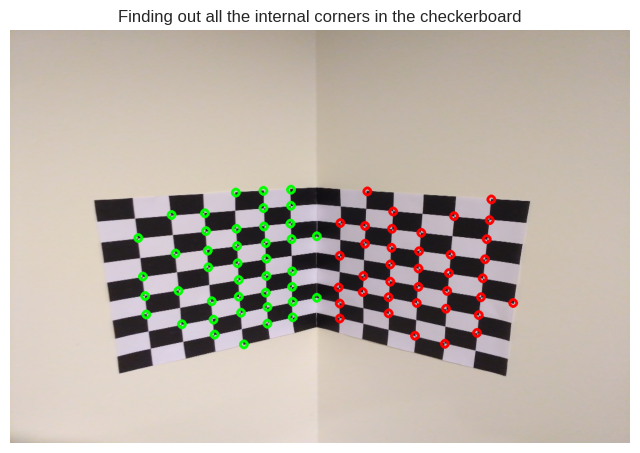

In [4]:
corners = cv2.goodFeaturesToTrack(img_gray, maxCorners=80, qualityLevel=0.6,  minDistance=10)
corners = np.intp(corners).reshape(-1, 2)
img_corners = img.copy()
points_3d = []

for corner in corners:
    points_3d.append([corner[0], corner[1], 0] if corner[0] <= 540 else
                     [540, corner[1], -corner[0] + 540])
    color = (255, 0, 0) if corner[0] >= 540 else (0, 255, 0)
    img_corners = cv2.circle(img_corners, (int(corner[0]), int(corner[1])), 6, color, 4)
    
    
plt.imshow(img_corners)
plt.title("Finding out all the internal corners in the checkerboard")
plt.axis('off')

print(f"Total corners found: {len(corners)}")

#### 2. Implementing Camera Calibration
Used the Direct Linear Transform method for finding the Projection Matrix (P) of the camera. For this task, the world origin is considered to be the top leftmost corner. 

##### 2.1 Finding 3D-2D point correspondences
For this task, we divide the image into two halves and find correspondences seperately. We then find the corners in each image (2D points) and also save the 3D points by observing the order in which ```cv2.findChessboardCorners()``` return the corners. For example, for the left image the corners are returned starting from the bottom left point and hence we store the 3D point from our assumed world origin accordingly. 

Also, we maintain tranformation matrices for 2D and 3D points for normalization as well as de-normalization purposes.

In [5]:

def get_correspondences(img, first_half=True):
    if first_half:
        img[:, 540:] = np.zeros_like(img[:, 540:])
    else:
        img[:, :540] = np.zeros_like(img[:, :540])
    
    ret, corners = cv2.findChessboardCorners(img, (8, 5))
    corners = corners.reshape(-1, 2)
    points_2d = corners[np.argsort(corners[:, 0])]
    points_3d = []
    
    for i in range(5):
        for j in range(8):
            if first_half:
                points_3d.append([2 + 2*i, 2 + 2*j, 0])
            else:
                points_3d.append([14, 16 - 2*j, -2*i - 4])
    
    return np.array(points_2d), np.array(points_3d)

T_2d = np.array([
    [2/1080, 0,     -1],
    [0,      2/720, -1],
    [0,      0,      1]
])

T_3d = np.array([
    [1/20, 0,    0,    0],
    [0,    1/20, 0,    0],
    [0,    0,    1/20, 0],
    [0,    0,    0,    1]
])

points_2d_left, points_3d_left = get_correspondences(img_gray.copy(), first_half=True)
points_2d_right, points_3d_right = get_correspondences(img_gray.copy(), first_half=False)

points_2d = np.concatenate([points_2d_left, points_2d_right], axis=0)
points_3d = np.concatenate([points_3d_left, points_3d_right], axis=0)

points_2d.shape, points_3d.shape

((80, 2), (80, 3))

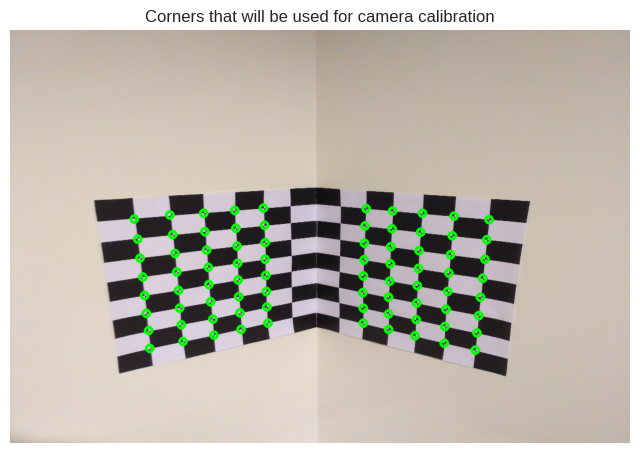

In [6]:
img_corners = img.copy()

for corner in points_2d:
    img_corners = cv2.circle(img_corners, (int(corner[0]), int(corner[1])), 6, (0, 255, 0), 3)
    
plt.imshow(img_corners)
plt.title('Corners that will be used for camera calibration')
plt.axis('off')
plt.show()


##### 2.2 Normalizing the 2D and 3D points for numerical stability while computing the SVD.
This is done by multiplying the points with the normalization transformation matrix computed above.

In [7]:

points_2d = np.hstack((points_2d, np.ones((len(points_2d), 1)))) @ T_2d.T
points_3d = np.hstack((points_3d, np.ones((len(points_3d), 1)))) @ T_3d.T

points_2d, points_3d = points_2d[:, :-1], points_3d[:, :-1]

points_2d.shape, points_3d.shape

((80, 2), (80, 3))

##### 2.3 Finding P and decomposing P into K, R, t

1. We compute P using DLT.
2. We find K, R, t by the following:

    $P = [H | h]$ \
    $t = -H^{-1} h$ \
    $q, r = $ QR($H^{-1}$) 
    
    $R = q^{T}$ \
    $K = r^{-1}$ \
    $K = \frac{K}{K_{33}}$

In [8]:
def find_PKRt(points_2d, points_3d):
    A = []

    for p3d, p2d in zip(points_3d, points_2d):
        X, Y, Z = p3d
        x, y = p2d
        axi = [-X, -Y, -Z, -1,  0,  0,  0,  0, x*X, x*Y, x*Z, x]
        ayi = [0,   0,  0,  0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y]
        A.append(axi)
        A.append(ayi)
    
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    H, h = P[:3, :3], P[:, -1]
    Xo = -np.linalg.inv(H) @ h
    
    q, r = np.linalg.qr(np.linalg.inv(H))
    R = q.T
    K = np.linalg.inv(r)
    K = K/K[-1, -1]

    invert = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])

    R = invert @ R
    K = K @ invert
        
    return P, K, R, Xo


P, K, R, Xo = find_PKRt(points_2d, points_3d)
indices = np.random.choice(80, 15, replace=False).tolist()
P2, K2, R2, Xo = find_PKRt(points_2d[indices], points_3d[indices])


In [10]:
print(f"P: \n{P}\n")
print(f"K: \n{K}\n")
print(f"R: \n{R}\n")
print(f"Xo: \n{Xo}\n")


P: 
[[ 0.46236394  0.00187216 -0.42458863 -0.33032278]
 [-0.08720996  0.44941478 -0.08632196 -0.07315182]
 [ 0.162621    0.056493    0.19483134  0.45480682]]

K: 
[[ 2.41178688 -0.02848651 -0.10987764]
 [ 0.          1.78991545 -0.08301643]
 [ 0.          0.          1.        ]]

R: 
[[ 0.76399207  0.02441052 -0.64476371]
 [-0.15839115  0.97580254 -0.15073698]
 [ 0.6254825   0.21728672  0.74937182]]

Xo: 
[-0.68270233 -0.30968286 -1.80635462]



#### 3. Drawing the Wireframe of the Checkerboard

In [11]:
outer_corners = np.array([
    [0, 0, 0, 1],
    [14, 0, 0, 1],
    [14, 0, -14, 1],
    [14, 18, -14, 1],
    [14, 18, 0, 1],
    [0, 18, 0, 1]
])

coords = (outer_corners @ T_3d.T) @ P.T
coords = coords/coords[:, -1].reshape(6, 1)

coords = coords @ np.linalg.inv(T_2d).T
coords

array([[147.80205389, 302.09705496,   1.        ],
       [533.66783771, 275.04038693,   1.        ],
       [902.96193011, 298.55907291,   1.        ],
       [866.64576495, 606.43169042,   1.        ],
       [535.65629523, 517.06399649,   1.        ],
       [189.03738134, 595.88571277,   1.        ]])

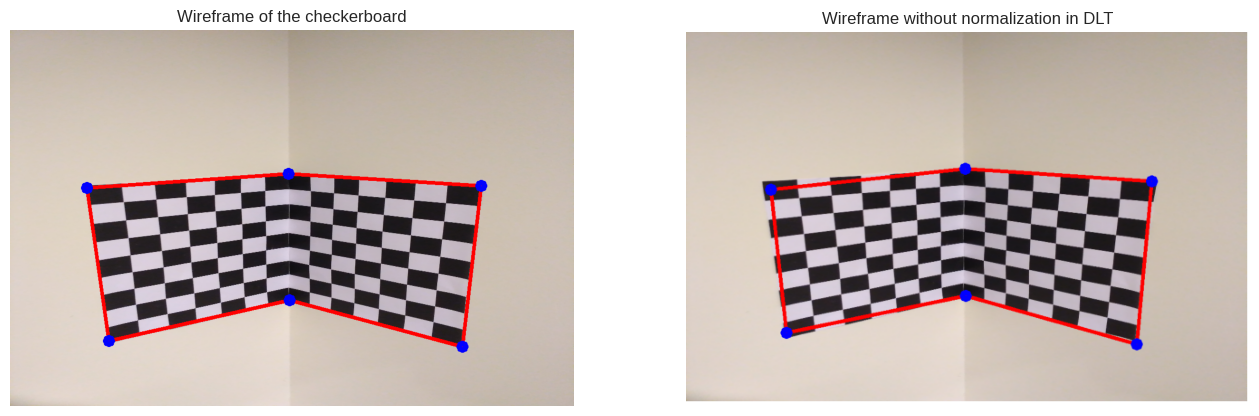

In [13]:
img_final = img.copy()

for i in range(len(coords)):
    img_final = cv2.line(img_final, 
                         (int(coords[i][0]), int(coords[i][1])), 
                         (int(coords[(i+1) % len(coords)][0]), int(coords[(i+1) % len(coords)][1])), 
                         (255, 0, 0), 5)

for corner in coords:
    img_final = cv2.circle(img_final, (int(corner[0]), int(corner[1])), 6, (0, 0, 255), 10)
    

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.imshow(img_final)
plt.axis('off')
plt.title('Wireframe of the checkerboard')

plt.subplot(1,2,2)
plt.imshow(plt.imread('./calibrated_no_norm.png'))
plt.axis('off')
plt.title('Wireframe without normalization in DLT')
plt.show()

##### Observation
We observe that the our wireframe perfectly fits the object. Our computation is accurate probably because we are using 80 points for DLT. Also, not normalizing the points led to deformed wireframe.

#### 4. Computing roll, pitch, yaw from R
Assuming the rotation matrix was constructed as $R = R_{x}(\phi) R_{y}(\theta) R_{z}(\gamma)$

$\phi = tan^{-1}(\frac{R_{yz}}{R_{zz}})$ \
$\theta = -sin^{-1}(R_{xz})$ \
$\gamma = tan^{-1}(\frac{R_{xy}}{R_{xx}})$



In [33]:
R = cv2.Rodrigues(R[0])[0]

phi = np.rad2deg(np.arctan2(R[1, 0], R[-1, -1]))
theta = np.rad2deg(-np.arcsin(R[0, -1]))
gamma = np.rad2deg(np.arctan2(R[0, 1], R[0, 0]))

print(f"Roll: {phi:.4f} Pitch: {theta:.4f} Yaw: {gamma:4f}")

Roll: 9.9621 Pitch: -6.3980 Yaw: -0.185680


## Q2. OpenCV Calibration

In [14]:

#* helper function for drawing corners and wireframe 
def draw_corners(img, corners, color=[0, 0, 255.0], connect_lines=False):
    img = img.copy()        
    n = len(corners)
    
    if connect_lines:
        for i in range(n):
            img = cv2.line(img, 
                           pt1=(int(corners[i][0]), int(corners[i][1])), 
                           pt2=(int(corners[(i + 1) % n][0]), int(corners[(i + 1)%n][1])),
                           color=[255, 0, 0],
                           thickness=4)

    for corner in corners:
        img = cv2.circle(img, (int(corner[0]), int(corner[1])), radius=5, color=color, thickness=5)

    return img

#* denormalizing the points since normalizing is not necessary for cv2 function
points_3d = (np.hstack((points_3d, np.ones((len(points_3d), 1)))) @ np.linalg.inv(T_3d).T)[:, :-1]
points_2d = (np.hstack((points_2d, np.ones((len(points_2d), 1)))) @ np.linalg.inv(T_2d).T)[:, :-1]


#### Q1. Camera calibration using OpenCV and plotting the wireframe

In [16]:

#* initial guess for the camera matrix
camera_guess = np.array([
    [img.shape[0], 0, img.shape[0]/2],
    [0, img.shape[1], img.shape[1]/2],
    [0, 0, 1]
])

flags = cv2.CALIB_USE_INTRINSIC_GUESS | cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6 | cv2.CALIB_ZERO_TANGENT_DIST

_, K, dist_coeff, R, t = cv2.calibrateCamera(objectPoints=[points_3d.astype(np.float32).reshape(-1, 3)], 
                                             imagePoints=[points_2d.astype(np.float32).reshape(-1, 1, 2)],
                                             imageSize=img_gray.shape[::-1], 
                                             flags=flags, 
                                             cameraMatrix=camera_guess.copy(), 
                                             distCoeffs=None)

_, K2, dist_coeff2, R2, t2 = cv2.calibrateCamera(objectPoints=[points_3d.astype(np.float32).reshape(-1, 3)], 
                                                imagePoints=[points_2d.astype(np.float32).reshape(-1, 1, 2)],
                                                imageSize=img_gray.shape[::-1], 
                                                flags=cv2.CALIB_USE_INTRINSIC_GUESS, 
                                                cameraMatrix=camera_guess, 
                                                distCoeffs=None)
print("K:", K)
print("R:", R[0])
print("t:", t[0])

K: [[1.23847922e+03 0.00000000e+00 5.34635324e+02]
 [0.00000000e+00 6.14535978e+02 3.42255082e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
R: [[ 0.21724796]
 [-0.75513113]
 [-0.08914504]]
t: [[-10.23460656]
 [ -2.30022294]
 [ 32.46405315]]


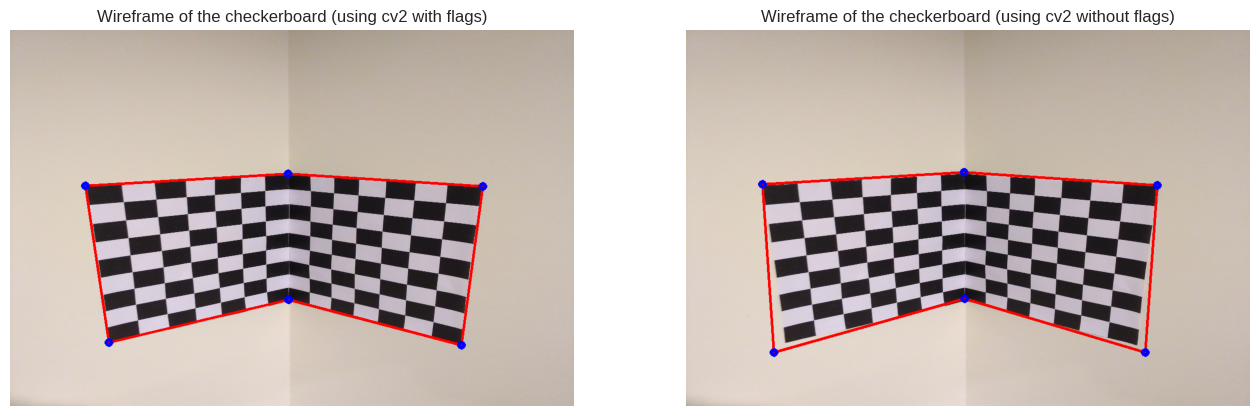

In [17]:
corners = cv2.projectPoints(outer_corners[:, :3].astype(np.float32).reshape(-1, 3), rvec=R[0], cameraMatrix=K, distCoeffs=dist_coeff, tvec=t[0])[0].reshape(-1, 2)
corners2 = cv2.projectPoints(outer_corners[:, :3].astype(np.float32).reshape(-1, 3), rvec=R2[0], cameraMatrix=K2, distCoeffs=dist_coeff2, tvec=t2[0])[0].reshape(-1, 2)

img_corners = draw_corners(img, corners, color=[0, 0, 255.0], connect_lines=True)
img_corners2 = draw_corners(img, corners2, color=[0, 0, 255.0], connect_lines=True)
    
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img_corners)
plt.title('Wireframe of the checkerboard (using cv2 with flags)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corners2)
plt.title('Wireframe of the checkerboard (using cv2 without flags)')
plt.axis('off')

plt.show()


##### Observations
Even for cv2, we observe that the wireframe perfectly fits the object. Although, we have to use the following flags to get the desired result: \
```flags = cv2.CALIB_USE_INTRINSIC_GUESS | cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6 | cv2.CALIB_ZERO_TANGENT_DIST```

Without these flags we see significant distortion in the wireframe.

#### Q2. Repeating the same process as Q1 for a new image

In [18]:
def calibrate_camera(gray, pattern_size, square_size, camera_guess):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size

    objpoints, imgpoints = [], []

    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
          
    ret, K, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints, imageSize=gray.shape[::-1], flags=flags, distCoeffs=None, cameraMatrix=camera_guess)

    return K, dist_coeff, rvecs, tvecs[0], 


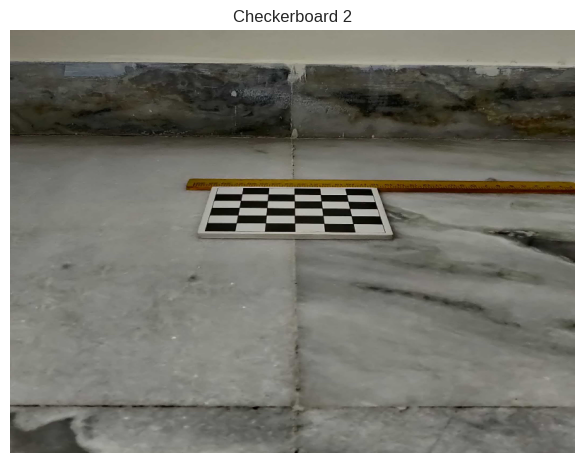

In [19]:
img_2 = plt.imread('./Data/assign1.jpg')
img_2 = cv2.resize(img_2, (800, 600))
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
plt.imshow(img_2)
plt.title('Checkerboard 2')
plt.axis('off')
plt.show()

In [20]:
K, dist_coeff, R, t = calibrate_camera(img_2_gray.copy(), (5, 5), 2, camera_guess=camera_guess)

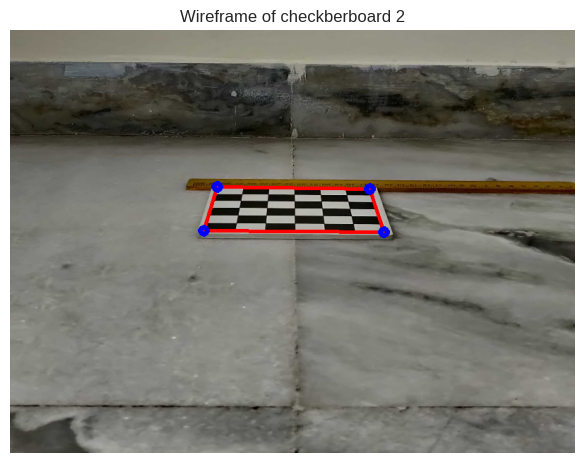

In [21]:
outer_corners = np.array([
    [-2, -2, 0.0],
    [10, -2, 0],
    [10, 10, 0.0],
    [-2, 10, 0],
])

corners = cv2.projectPoints(outer_corners.reshape(-1, 3), rvec=R[0], cameraMatrix=K, distCoeffs=dist_coeff, tvec=t)[0].reshape(-1, 2)

img_2_corners = draw_corners(img_2, corners, color=[0, 0, 255.0], connect_lines=True)
    
plt.imshow(img_2_corners)
plt.title('Wireframe of checkberboard 2')
plt.axis('off')
plt.show()


If point are co-planar while performing DLT, it would lead to rank deficiency to the system of equations formed during DLT calibration. This would lead to multiple solutions for P and there is no way to uniquely determine one solution.

#### Q3. World origin

We initially assumed the world origin to be the top left corner. So, give P we compute the image origin by $P[0, 0, 0, 1]^{T}$. The image coordinates obtained are $[147.80, 302.09].$ This is indeed correct as we can see below in the plot. This also proves that our computed $P$ is correct.

Origin in image: [147.80205389 302.09705496]


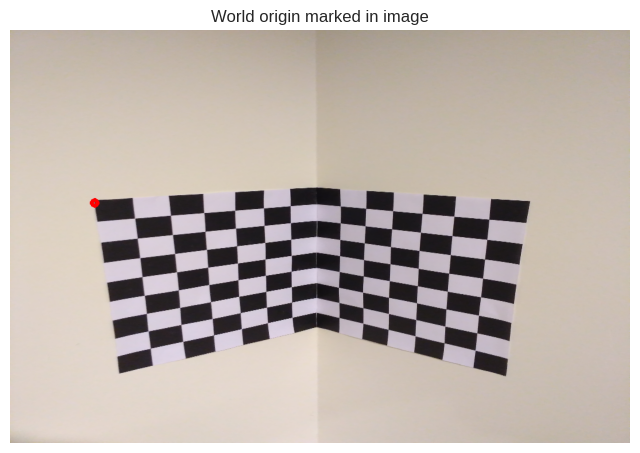

In [22]:
world_origin = np.array([0, 0, 0, 1])
origin_image = P @ world_origin.reshape(-1, 1)
origin_image = origin_image/origin_image[-1]
origin_image = np.linalg.inv(T_2d) @ origin_image

print("Origin in image:", origin_image.reshape(-1)[:-1])

img_origin = draw_corners(img, [origin_image], color=[255, 0, 0])
plt.imshow(img_origin)
plt.title('World origin marked in image')
plt.axis('off')
plt.show()

## Q3. Moving the Chessboard

#### Q1. Moving the wireframe to the right by 10cm

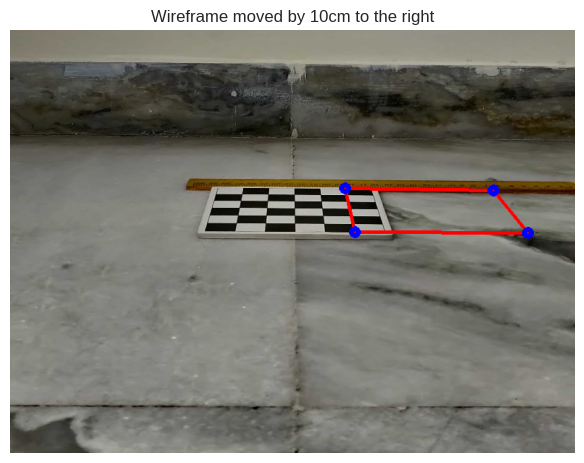

In [23]:
outer_corners_10 = np.array([
    [-2 + 10, -2, 0.0],
    [10 +10, -2, 0],
    [10 + 10, 10, 0.0],
    [-2 + 10, 10, 0],
])

corners = cv2.projectPoints(outer_corners_10.reshape(-1, 3), rvec=R[0], cameraMatrix=K, distCoeffs=dist_coeff, tvec=t)[0].reshape(-1, 2)
img_2_wireframe = draw_corners(img_2, corners, color=[0, 0, 255.0], connect_lines=True)
    
plt.imshow(img_2_wireframe)
plt.title('Wireframe moved by 10cm to the right')
plt.axis('off')
plt.show()

Does the wireframe look consistent with what you expect? 

Yes, from the above image we can see that the wireframe is shifted exactly by 10cm to the right (can be verified using the ruler).

#### Q2. Moving the pixels too along with wireframe

In [24]:
P = K @ np.hstack((cv2.Rodrigues(R[0])[0], t))
print(P)

[[ 1.36511221e+03 -3.66393331e+02  1.17180349e+02  2.31872497e+04]
 [ 4.10751527e+01  1.10310993e+02  8.24160796e+02  1.64715510e+04]
 [ 1.19948391e-01 -9.22272721e-01  3.67458041e-01  7.06260335e+01]]


0it [00:00, ?it/s]

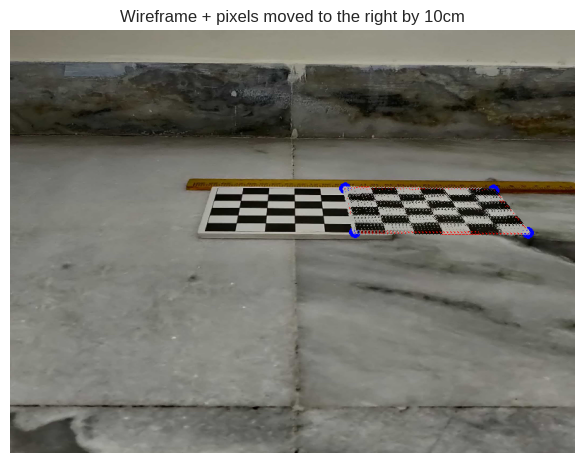

In [25]:
Xs = np.linspace(-2, -2 + 12, 50)
Ys = np.linspace(-2, -2 + 12, 50)

X, Y = np.meshgrid(Xs, Ys)
X, Y = X.reshape(-1), Y.reshape(-1)

img_shifted = img_2_wireframe.copy()
for x, y in tqdm(zip(X, Y)):
    corners = P @ np.array([x + 10, y, 0, 1]).reshape(-1, 1)
    point = P @ np.array([x, y, 0, 1]).reshape(-1, 1)
    
    point = point/point[-1]
    corners = corners/corners[-1]
    
    color = img_2[int(point[1])][int(point[0])]
    img_shifted = cv2.circle(img_shifted, (int(corners[0]), int(corners[1])), radius=3, color=[int(color[0]), int(color[1]), int(color[2])], thickness=1)

plt.imshow(img_shifted)
plt.title('Wireframe + pixels moved to the right by 10cm')
plt.axis('off')
plt.show()


Is the overlay consistent with what you expect?

Yes, the overlay is consistent as it matches the shifted wireframe. 

## References

1. <a href="https://docs.opencv.org/3.4/d6/d00/tutorial_py_root.html">OpenCV Documentation</a>
2. <a href="https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=h5ZqG0BZxOxOEsu9">Camera Calibration | First Principles of Computer Vision by  Shree Nayar</a>
3. <a href="https://youtu.be/3NcQbZu6xt8?si=0y88ZI2M_wyBzH41">DLT for Camera Calibration and Localization by Cyrill Stachiss</a>

## Challenges Faced and Learnings

Challenges:

1. Finding the 3D-2D correspondences was challenging because we had to figure out the order in which cv2 returns the chessboard corners
2. Executing cv2 functions were difficult, because most of the functions don't have proper documentation and it was difficult to find out the data types of the arguments to pass.

Learnings:
1. We got to learn about Camera Calibration using Direct Linear Transform.
2. We got to learn and use different functions of cv2. 
